In [1]:
%cd ../..

D:\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import numpy as np
import pandas as pd
import time
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path
from tqdm.autonotebook import tqdm
import warnings
import humanize

#If importing darts is throwing an error, import torch beforehand and then import darts
# import torch
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveMean,
    NaiveDrift,
    ExponentialSmoothing,
    AutoARIMA,
    ARIMA,
    Theta,
    FFT
)

from darts.metrics import mase, mse, mae, ope

from src.utils.ts_utils import forecast_bias
from src.utils.general import LogTime
from src.utils import plotting_utils
%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_3556/3788438326.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[2021-11-10 14:13:38,013] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


In [3]:
os.makedirs("imgs/chapter_4", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")

In [4]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title=""):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=12),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=12),
            )
        )
    return fig

In [13]:
#Readin the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"block_0-7_train_missing_imputed.parquet")
test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed.parquet")

print("Test DF Min and Max Date",test_df.timestamp.min(), test_df.timestamp.max())

# #Choosing a smaller backtesting window because of runtime issues
backtesting = test_df[test_df.timestamp.between(pd.Timestamp("2014-01-01"),pd.Timestamp("2014-01-08"))]
print("Backtesting DF Min and Max Date",backtesting.timestamp.min(), backtesting.timestamp.max())

Test DF Min and Max Date 2014-01-01 00:00:00 2014-02-27 23:30:00
Backtesting DF Min and Max Date 2014-01-01 00:00:00 2014-01-08 00:00:00


In [14]:
len(train_df.LCLid.unique())

399

In [15]:
#picking a single time series from the dataset for illustration
freq = train_df.iloc[0]['frequency']
ts_train = train_df.loc[train_df.LCLid=="MAC000193", ["timestamp","energy_consumption"]].set_index("timestamp")
ts_test = backtesting.loc[backtesting.LCLid=="MAC000193", ["timestamp","energy_consumption"]].set_index("timestamp")

# Baseline Forecasts

In [16]:
pred_df = pd.concat([ts_train, ts_test])
metric_record = []

ts_train = TimeSeries.from_series(ts_train)
ts_test = TimeSeries.from_series(ts_test)

In [17]:
def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }

def eval_model_backtest(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    ts = ts_train.append(ts_test)
    start = ts_test.time_index.min()
    # model.fit(ts_train)
    y_pred = model.historical_forecasts(ts, start=start, verbose=True)
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

In [18]:
from itertools import cycle
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    act_color = colors[0]
    colors = cycle(colors[1:])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].energy_consumption,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.9")),
                        name='Actual Consumption'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash='dot', color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

## Running Baseline Forecast for all consumers

In [19]:
lcl_ids = sorted(train_df.LCLid.unique())

### Naive Forecast

In [23]:
from src.utils.ts_utils import darts_metrics_adapter

In [42]:
name = "Naive"
naive_preds = []
naive_metrics = []
for lcl_id in tqdm(lcl_ids):
    # naive_model = NaiveSeasonal(K=1)
    tr = train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp")
    ts = test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp")
    tr_ts = pd.concat([tr, ts])
    tr_ts['naive_predictions'] = tr_ts['energy_consumption'].shift(1)
    y_pred = tr_ts.loc[ts.index].drop(columns="energy_consumption")
    metrics = {
        "Algorithm": name,
        "MAE": darts_metrics_adapter(mae,actual_series = ts, pred_series = y_pred),
        "MSE": darts_metrics_adapter(mse,actual_series = ts, pred_series = y_pred),
        "MASE": darts_metrics_adapter(mase,actual_series = ts, pred_series = y_pred, insample=tr.energy_consumption),
        "Forecast Bias": darts_metrics_adapter(forecast_bias,actual_series = ts, pred_series = y_pred)
    }
    # break
    # y_pred = format_y_pred(y_pred, "naive_predictions").to_frame()
    y_pred['LCLid'] = lcl_id
    metrics["LCLid"] = lcl_id
    y_pred['energy_consumption'] = ts.energy_consumption.values
    naive_preds.append(y_pred)
    naive_metrics.append(metrics)
    # break

  0%|          | 0/399 [00:00<?, ?it/s]

In [43]:
naive_pred_df = pd.concat(naive_preds)
naive_pred_df.head()

,naive_predictions,LCLid,energy_consumption
timestamp,,,
2014-01-01 00:00:00,0.452,MAC000002,0.496
2014-01-01 00:30:00,0.496,MAC000002,0.427
2014-01-01 01:00:00,0.427,MAC000002,0.469
2014-01-01 01:30:00,0.469,MAC000002,0.362
2014-01-01 02:00:00,0.362,MAC000002,0.452


In [44]:
naive_metric_df = pd.DataFrame(naive_metrics)
naive_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Naive,0.113096,0.043370,1.050211,0.083798,MAC000002
1,Naive,0.068882,0.020838,1.223502,-0.000646,MAC000005
2,Naive,0.074593,0.019293,1.122474,0.110074,MAC000017
3,Naive,0.117861,0.048693,1.080140,-0.004914,MAC000030
4,Naive,0.305592,0.237029,1.612927,0.040173,MAC000040


In [67]:
from src.utils import ts_utils

In [69]:
overall_metrics_naive = {
    "MAE": ts_utils.mae(naive_pred_df["energy_consumption"], naive_pred_df["naive_predictions"]),
    "MSE": ts_utils.mse(naive_pred_df.energy_consumption, naive_pred_df.naive_predictions),
    "meanMASE": naive_metric_df.MASE.mean(),
    "Forecast Bias": ts_utils.forecast_bias_aggregate(naive_pred_df.energy_consumption, naive_pred_df.naive_predictions)
}
overall_metrics_naive

{'MAE': 0.109260626,
 'MSE': 0.05374795,
 'meanMASE': 0.9956901105013407,
 'Forecast Bias': 4.8523125e-05}

### Seasonal Naive Forecast

In [23]:
from src.utils.ts_utils import darts_metrics_adapter

In [42]:
name = "Naive"
naive_preds = []
naive_metrics = []
for lcl_id in tqdm(lcl_ids):
    # naive_model = NaiveSeasonal(K=1)
    tr = train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp")
    ts = test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp")
    tr_ts = pd.concat([tr, ts])
    tr_ts['naive_predictions'] = tr_ts['energy_consumption'].shift(1)
    y_pred = tr_ts.loc[ts.index].drop(columns="energy_consumption")
    metrics = {
        "Algorithm": name,
        "MAE": darts_metrics_adapter(mae,actual_series = ts, pred_series = y_pred),
        "MSE": darts_metrics_adapter(mse,actual_series = ts, pred_series = y_pred),
        "MASE": darts_metrics_adapter(mase,actual_series = ts, pred_series = y_pred, insample=tr.energy_consumption),
        "Forecast Bias": darts_metrics_adapter(forecast_bias,actual_series = ts, pred_series = y_pred)
    }
    # break
    # y_pred = format_y_pred(y_pred, "naive_predictions").to_frame()
    y_pred['LCLid'] = lcl_id
    metrics["LCLid"] = lcl_id
    y_pred['energy_consumption'] = ts.energy_consumption.values
    naive_preds.append(y_pred)
    naive_metrics.append(metrics)
    # break

  0%|          | 0/399 [00:00<?, ?it/s]

In [43]:
naive_pred_df = pd.concat(naive_preds)
naive_pred_df.head()

,naive_predictions,LCLid,energy_consumption
timestamp,,,
2014-01-01 00:00:00,0.452,MAC000002,0.496
2014-01-01 00:30:00,0.496,MAC000002,0.427
2014-01-01 01:00:00,0.427,MAC000002,0.469
2014-01-01 01:30:00,0.469,MAC000002,0.362
2014-01-01 02:00:00,0.362,MAC000002,0.452


In [44]:
naive_metric_df = pd.DataFrame(naive_metrics)
naive_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Naive,0.113096,0.043370,1.050211,0.083798,MAC000002
1,Naive,0.068882,0.020838,1.223502,-0.000646,MAC000005
2,Naive,0.074593,0.019293,1.122474,0.110074,MAC000017
3,Naive,0.117861,0.048693,1.080140,-0.004914,MAC000030
4,Naive,0.305592,0.237029,1.612927,0.040173,MAC000040


In [67]:
from src.utils import ts_utils

In [69]:
overall_metrics_naive = {
    "MAE": ts_utils.mae(naive_pred_df["energy_consumption"], naive_pred_df["naive_predictions"]),
    "MSE": ts_utils.mse(naive_pred_df.energy_consumption, naive_pred_df.naive_predictions),
    "meanMASE": naive_metric_df.MASE.mean(),
    "Forecast Bias": ts_utils.forecast_bias_aggregate(naive_pred_df.energy_consumption, naive_pred_df.naive_predictions)
}
overall_metrics_naive

{'MAE': 0.109260626,
 'MSE': 0.05374795,
 'meanMASE': 0.9956901105013407,
 'Forecast Bias': 4.8523125e-05}

### FFT

In [38]:
name = "FFT"
fft_preds = []
fft_metrics = []
for lcl_id in tqdm(lcl_ids):
    fft_model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
    tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
    ts = TimeSeries.from_series(test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
    y_pred, metrics = eval_model(fft_model, tr, ts, name=name)
    y_pred = format_y_pred(y_pred, "fft_predictions").to_frame()
    y_pred['LCLid'] = lcl_id
    metrics["LCLid"] = lcl_id
    y_pred['energy_consumption'] = ts.data_array().to_series().values
    fft_preds.append(y_pred)
    fft_metrics.append(metrics)

  0%|          | 0/399 [00:00<?, ?it/s]

In [39]:
fft_pred_df = pd.concat(fft_preds)
fft_pred_df.head()

,fft_predictions,LCLid,energy_consumption
time,,,
2014-01-01 00:00:00,0.255057,MAC000002,0.496
2014-01-01 00:30:00,0.234834,MAC000002,0.427
2014-01-01 01:00:00,0.207254,MAC000002,0.469
2014-01-01 01:30:00,0.175136,MAC000002,0.362
2014-01-01 02:00:00,0.144155,MAC000002,0.452


In [40]:
fft_metric_df = pd.DataFrame(fft_metrics)
fft_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,FFT,0.161086,0.071382,1.495855,19.789894,MAC000002
1,FFT,0.060454,0.014239,1.073792,19.206942,MAC000005
2,FFT,0.084586,0.019561,1.272841,-3.236648,MAC000017
3,FFT,0.184020,0.075877,1.686455,-19.180533,MAC000030
4,FFT,0.365551,0.184259,1.929392,-18.135196,MAC000040


In [41]:
actual_series = TimeSeries.from_values(fft_pred_df.energy_consumption.values)
pred_series = TimeSeries.from_values(fft_pred_df.fft_predictions.values)

In [42]:
overall_metrics_fft = {
    "MAE": mae(actual_series = actual_series, pred_series = pred_series),
    "MSE": mse(actual_series = actual_series, pred_series = pred_series),
    "meanMASE": fft_metric_df.MASE.mean(),
    "Forecast Bias": ope(actual_series = actual_series, pred_series = pred_series)
}
overall_metrics_fft

{'MAE': 0.18095471348575962,
 'MSE': 0.10185350593419754,
 'meanMASE': 1.7935677692251986,
 'Forecast Bias': 11.560564558166767}

## Evaluation of Baseline Forecast

In [43]:
p_df = pd.DataFrame([overall_metrics_fft, overall_metrics_theta], index=["FFT","Theta"])

p_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen')

,MAE,MSE,meanMASE,Forecast Bias
FFT,0.181,0.102,1.794,11.56%
Theta,0.233,0.162,2.092,15.25%


In [44]:
baseline_pred_df = theta_pred_df.reset_index().merge(fft_pred_df.reset_index().drop(columns='energy_consumption'), on=['time','LCLid'], how='outer')

In [45]:
baseline_metrics_df = pd.concat([theta_metric_df, fft_metric_df])
baseline_metrics_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Theta,0.195943,0.072140,1.819537,-21.151956,MAC000002
1,Theta,0.077784,0.013287,1.381620,-25.762581,MAC000005
2,Theta,0.124269,0.033778,1.869995,77.886231,MAC000017
3,Theta,0.132909,0.065851,1.218045,27.962869,MAC000030
4,Theta,0.312368,0.166005,1.648694,-4.295670,MAC000040


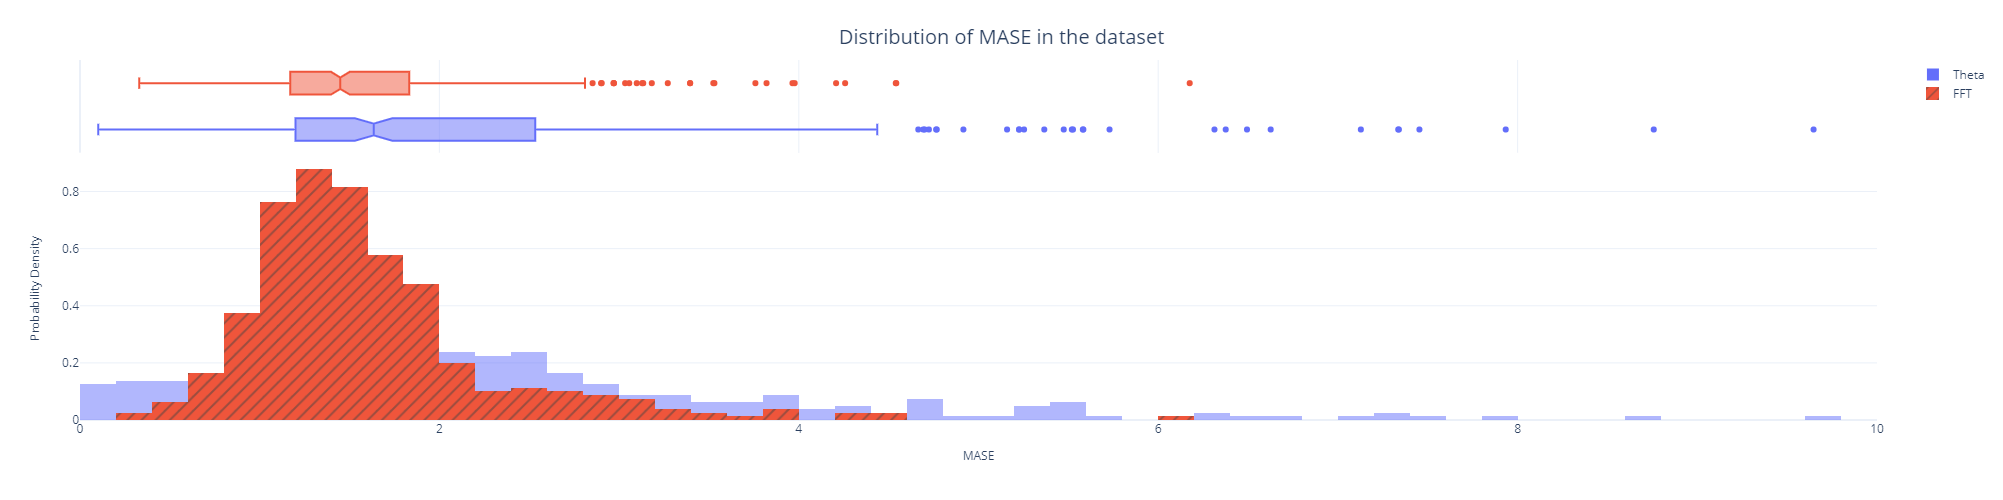

In [46]:
fig = px.histogram(baseline_metrics_df, 
                   x="MASE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,10])
fig.write_image("imgs/chapter_4/mase_dist.png")
fig.show()

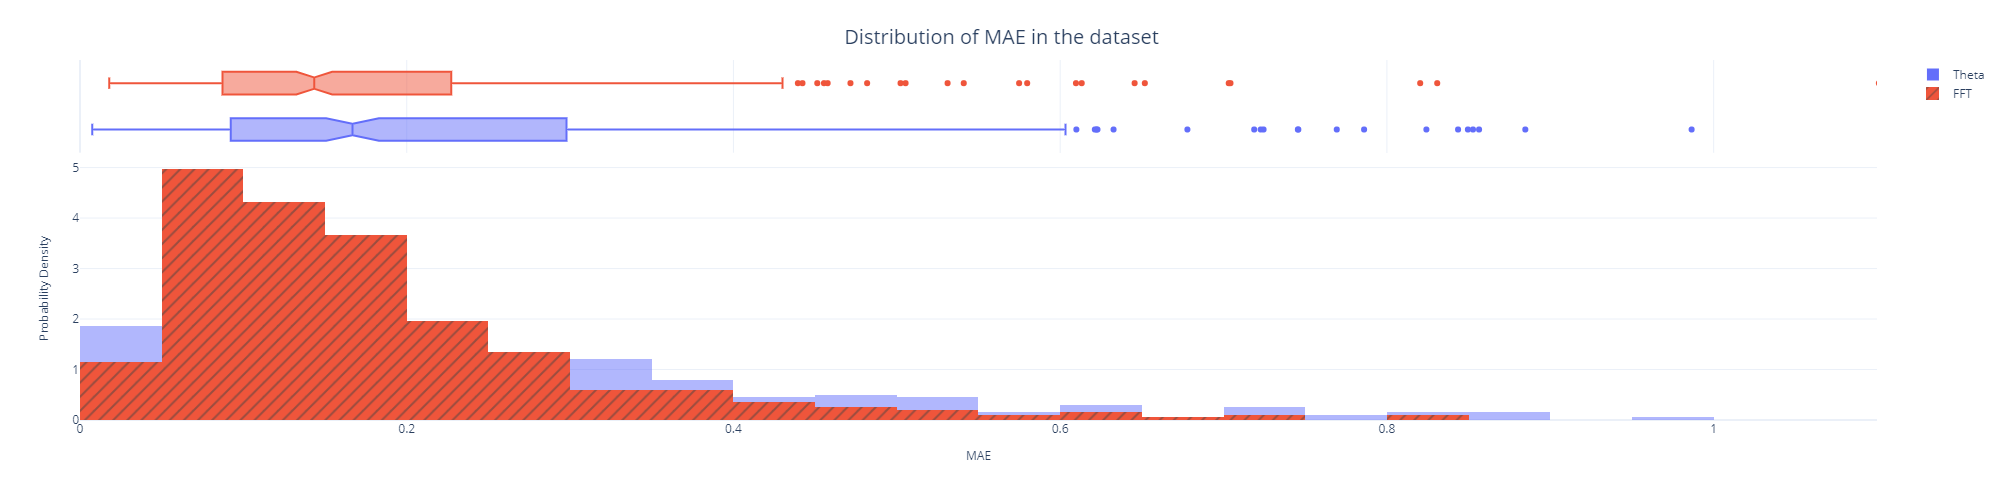

In [47]:
fig = px.histogram(baseline_metrics_df, 
                   x="MAE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
fig.write_image("imgs/chapter_4/mae_dist.png")
fig.update_layout(xaxis_range=[0,1.1])
fig.show()

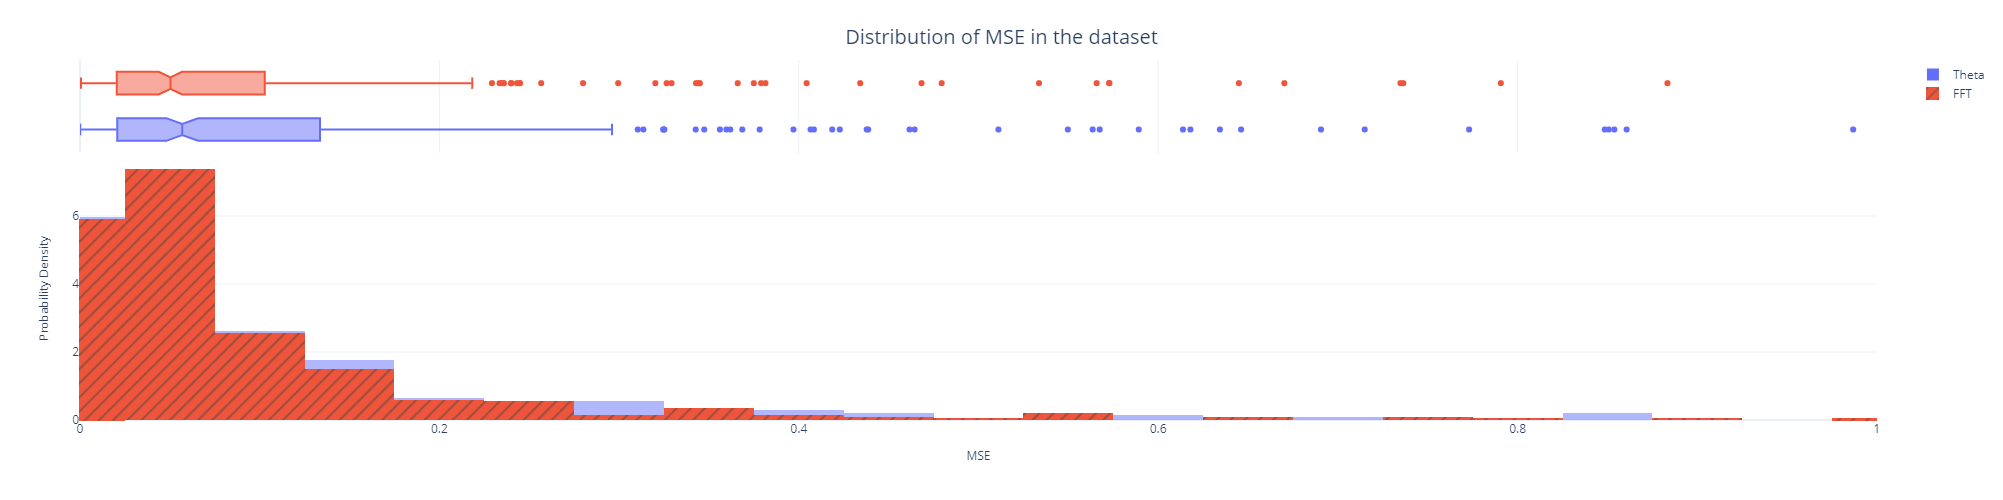

In [48]:
fig = px.histogram(baseline_metrics_df, 
                   x="MSE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,1])
fig.write_image("imgs/chapter_4/mse_dist.png")
fig.show()

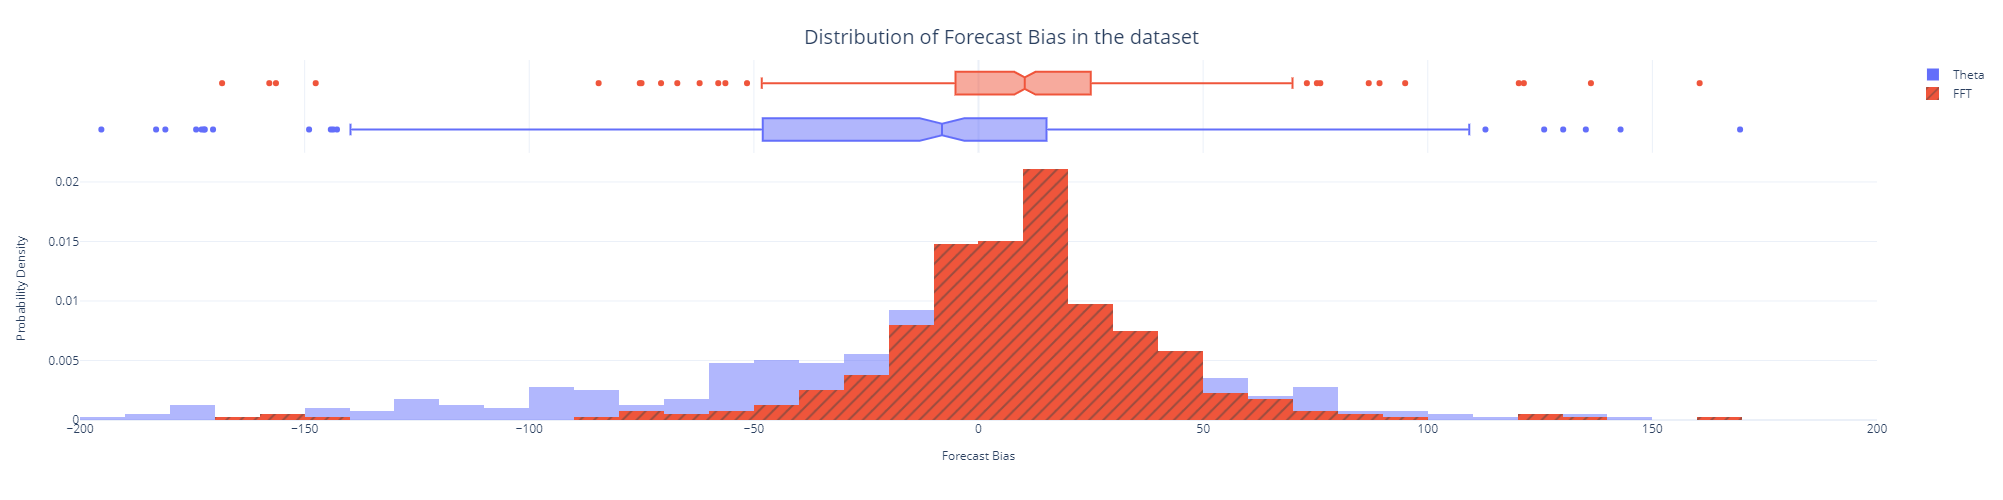

In [49]:
fig = px.histogram(baseline_metrics_df, 
                   x="Forecast Bias", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=250,
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="Forecast Bias", ylabel="Probability Density", title="Distribution of Forecast Bias in the dataset")
fig.update_layout(xaxis_range=[-200,200])
fig.write_image("imgs/chapter_4/bias_dist.png")
fig.show()

## Saving the Baseline Forecasts and Metrics

In [50]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [51]:
baseline_pred_df.to_pickle(output/"baseline_prediction_df.pkl")
baseline_metrics_df.to_pickle(output/"baseline_metrics_df.pkl")
p_df.to_pickle(output/"baseline_aggregate_metrics.pkl")